Using device: cpu
True viscosity ν = 0.01
Initial viscosity guess = 0.001
Initialized nu = 0.001, requires_grad = True
BurgerDenseNet architecture ready

Pretraining with classical gradient descent (using adjoint-based Hessian)...
Starting pretraining with classical gradient descent...
[Hessian Update] Inner H = 9.500e-01, Outer H = 1.077e+00
[Pretrain] iter 0: Residual loss = 3.453e-02, Grad norm = 1.052e+00, H_inner = 9.500e-01
[Hessian Update] Inner H = 9.050e-01, Outer H = 1.069e+00
[Pretrain] iter 50: Residual loss = 4.815e-05, Grad norm = 3.021e-02, H_inner = 9.050e-01
[Hessian Update] Inner H = 8.645e-01, Outer H = 1.062e+00
[Pretrain] iter 100: Residual loss = 5.117e-06, Grad norm = 2.924e-03, H_inner = 8.645e-01
[Hessian Update] Inner H = 8.280e-01, Outer H = 1.056e+00
[Pretrain] iter 150: Residual loss = 2.404e-06, Grad norm = 4.687e-04, H_inner = 8.280e-01
[Hessian Update] Inner H = 7.952e-01, Outer H = 1.050e+00
[Pretrain] iter 200: Residual loss = 1.866e-06, Grad norm = 1.

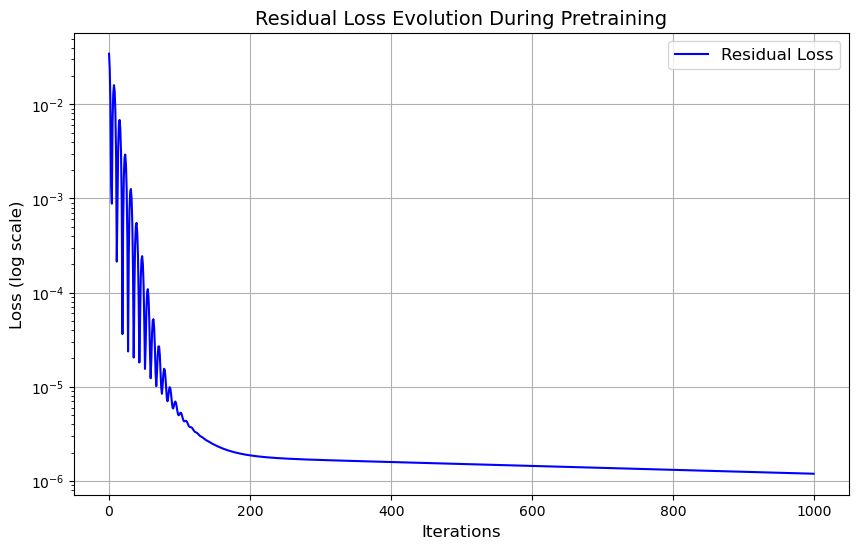

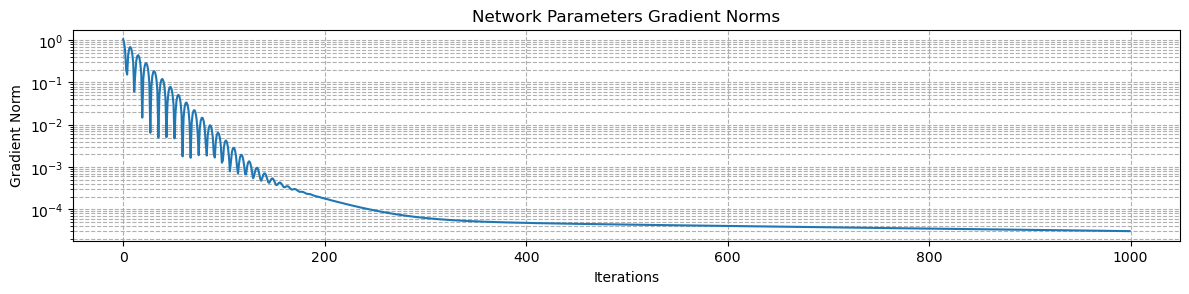

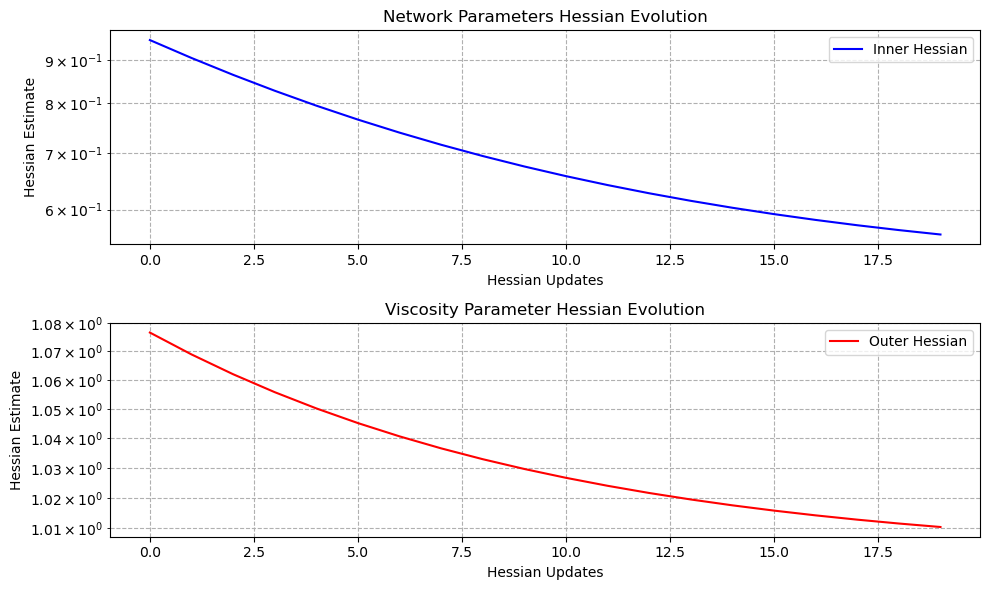


Finetuning with classical gradient descent (using adjoint-based Hessian)...
Starting finetuning with classical gradient descent...
[Hessian Update] Inner H = 5.547e-01, Outer H = 1.009e+00
[Hessian Update] Inner H = 5.492e-01, Outer H = 1.008e+00
[Finetune] iter 0: Data loss = 4.952e-02, Residual loss = 1.190e-06, Current ν = 0.00177, H_outer = 1.008e+00, ν grad norm = -1.558e-02
[Hessian Update] Inner H = 5.443e-01, Outer H = 1.008e+00
[Finetune] iter 50: Data loss = 3.011e-02, Residual loss = 7.466e-05, Current ν = 0.17309, H_outer = 1.008e+00, ν grad norm = 1.838e-03
[Hessian Update] Inner H = 5.399e-01, Outer H = 1.043e+00
[Finetune] iter 100: Data loss = 2.801e-02, Residual loss = 8.307e-05, Current ν = 0.02250, H_outer = 1.043e+00, ν grad norm = 1.346e-03
[Hessian Update] Inner H = 1.695e+00, Outer H = 6.983e+00
[Finetune] iter 150: Data loss = 9.065e-03, Residual loss = 1.034e-02, Current ν = 0.00000, H_outer = 6.983e+00, ν grad norm = -5.431e-01
[Hessian Update] Inner H = 3.41

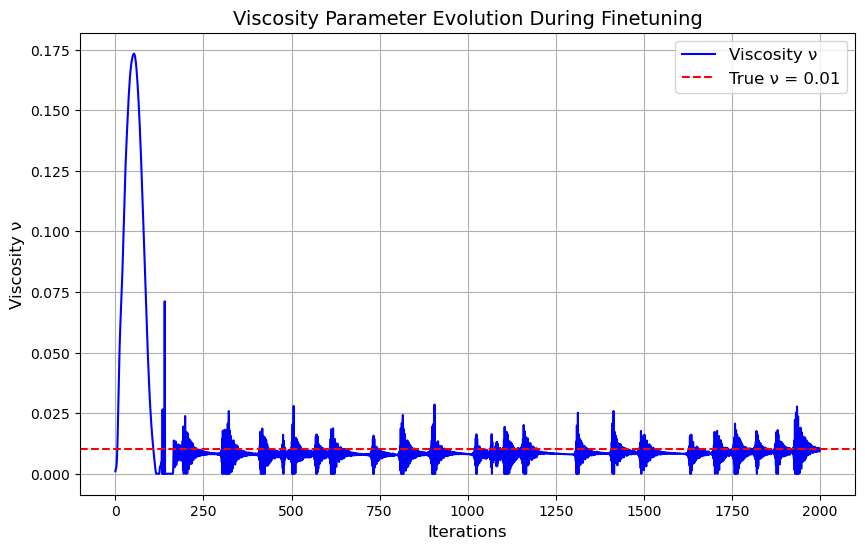

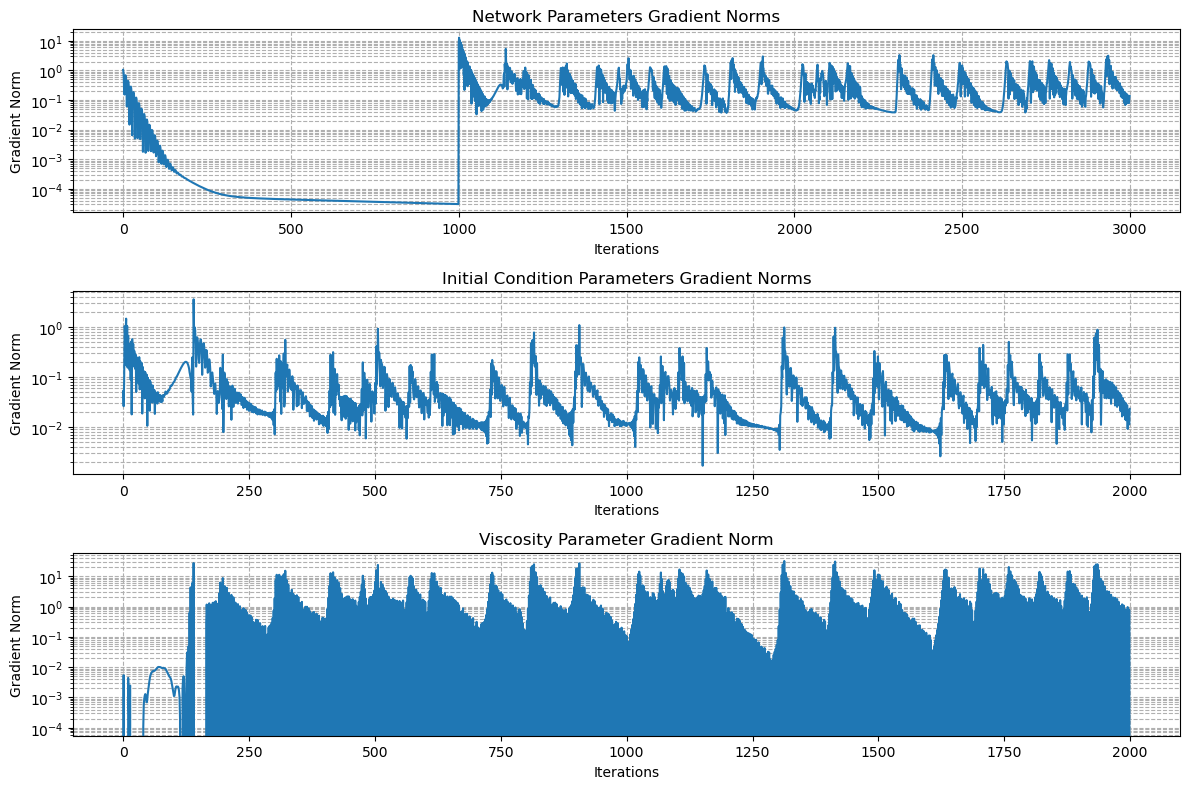

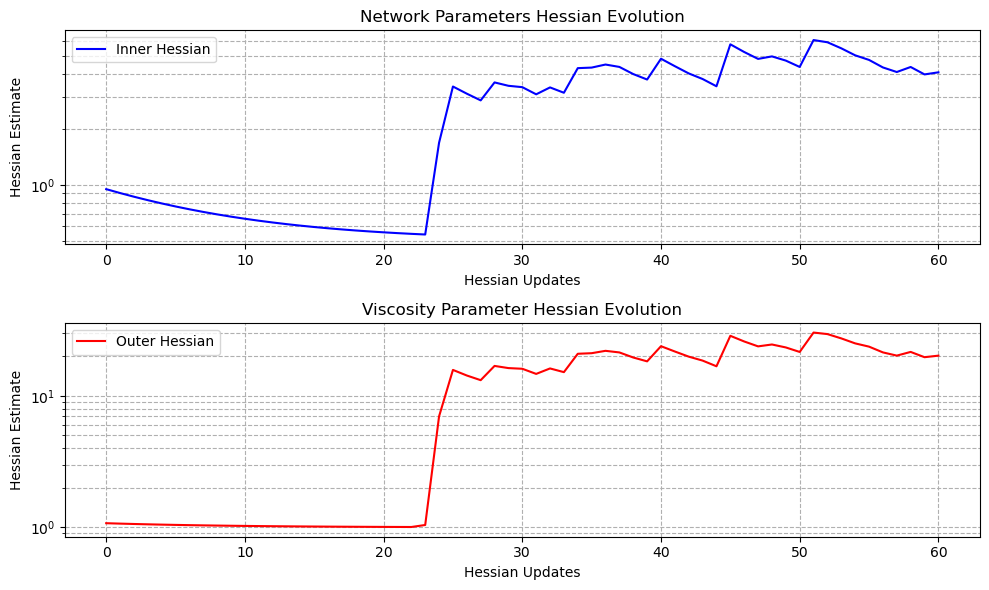

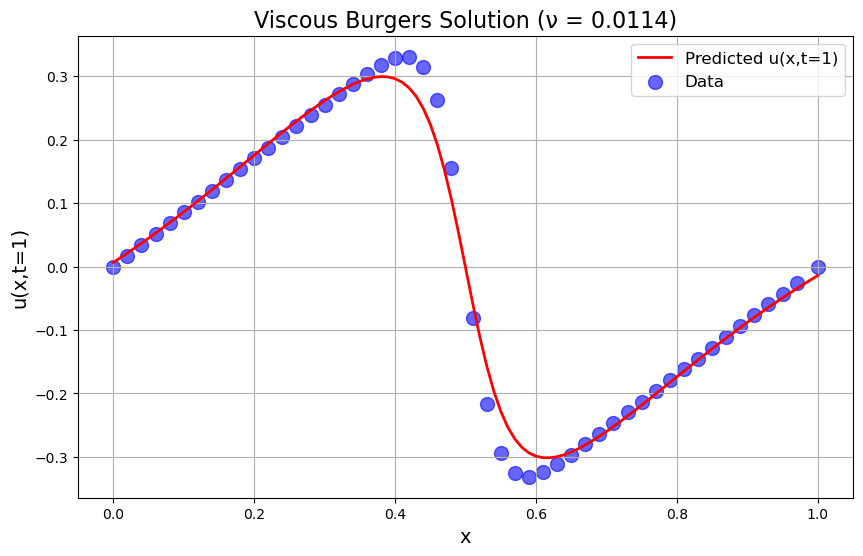

Identified viscosity ν = 0.011390
True viscosity ν = 0.01
Relative error: 13.90%


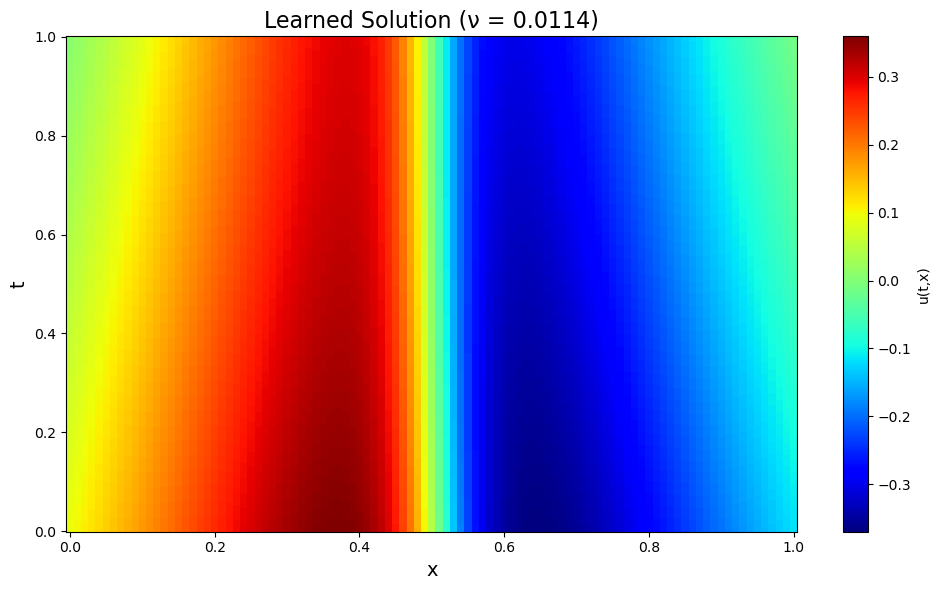

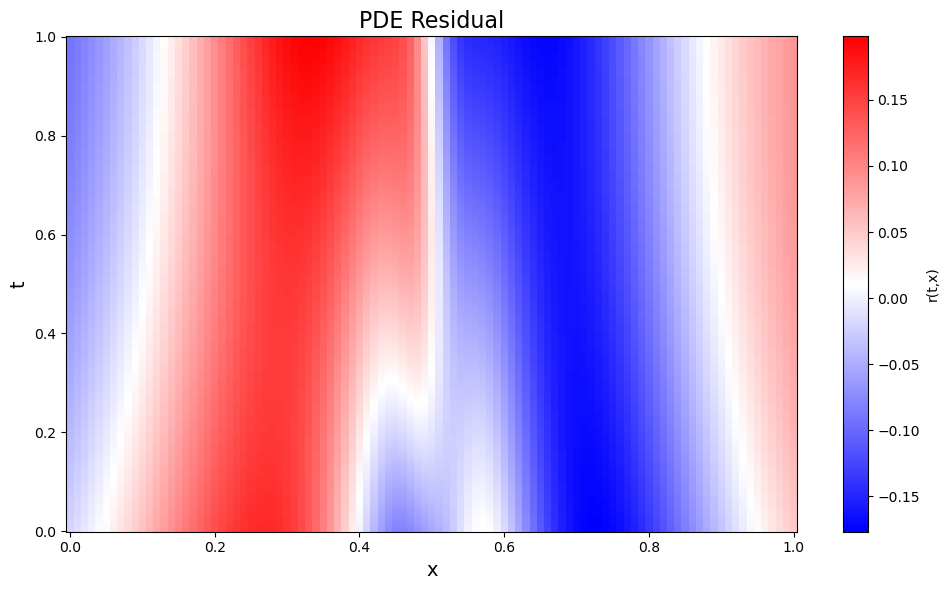

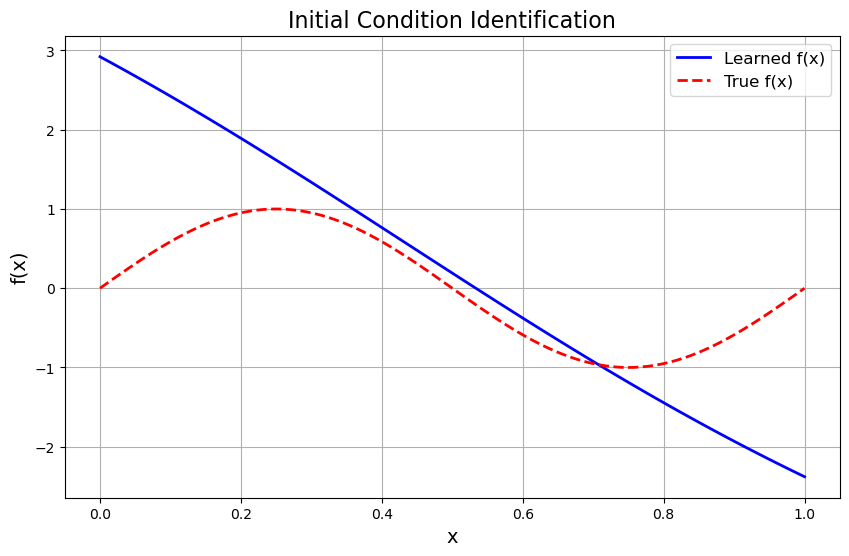

Final Validation Data Loss = 6.011e-04

--- Impact of Adjoint-Based Hessian ---
The adjoint-based Hessian estimation:
1. Provides curvature information about the loss landscape
2. Helps scale learning rates for different parameter groups
3. Gives insight into the conditioning of the bilevel optimization problem
4. Highlights the challenges of PDE parameter identification

Analysis of Hessian influence on learning dynamics:
Final Inner Hessian (network): 4.07e+00
Final Outer Hessian (viscosity): 2.02e+01
Hessian ratio (outer/inner): 4.95

The outer problem (viscosity identification) has a higher Hessian magnitude,
indicating higher curvature and potentially more difficulty in optimization.

Hessian-normalized network gradient: 1.19e-01
Hessian-normalized viscosity gradient: 2.47e-06
Normalized gradient ratio: 2.0716543406489683e-05

The adjoint field visualization shows how the solution sensitivity
propagates backward in time from data measurements, which is crucial
for understanding pa

In [7]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set precision to double for better numerical stability
torch.set_default_dtype(torch.float64)

##############################################################################
# 1. Forward Solver: Viscous Burgers Equation via Explicit Finite Difference
##############################################################################
def simulate_viscous_burgers(u0_func, nu=0.01, x_domain=(0,1), t_domain=(0,1), Nx=101, Nt=200):
    """
    Solve the 1D viscous Burgers' equation:
         u_t + u*u_x = nu*u_xx,
    with Dirichlet boundary conditions using an explicit finite-difference scheme.
    """
    x_arr = np.linspace(x_domain[0], x_domain[1], Nx)
    t0, t1 = t_domain
    dt = (t1-t0) / (Nt-1)
    dx = (x_domain[1]-x_domain[0]) / (Nx-1)
    # CFL conditions: convection and diffusion
    cfl_conv = 0.2 * dx / (1.0 + 1e-6)
    cfl_diff = 0.2 * dx**2 / (nu + 1e-6)
    dt = min(dt, cfl_conv, cfl_diff)
    Nt = int((t1-t0)/dt) + 1
    t_arr = np.linspace(t0, t1, Nt)
    U = np.zeros((Nt, Nx))
    U[0, :] = u0_func(x_arr)
    U[0, 0] = 0.0
    U[0, -1] = 0.0
    for n in range(Nt-1):
        u_n = U[n, :].copy()
        u_n[0] = 0.0
        u_n[-1] = 0.0
        u_next = u_n.copy()
        for i in range(1, Nx-1):
            ux = (u_n[i+1] - u_n[i-1]) / (2*dx)
            uxx = (u_n[i+1] - 2*u_n[i] + u_n[i-1]) / (dx**2)
            # Burgers: u_t = -u*u_x + nu*u_xx
            u_next[i] = u_n[i] + dt * (-u_n[i]*ux + nu*uxx)
        U[n+1, :] = u_next
    return t_arr, x_arr, U

##############################################################################
# 2. Dataset Construction
##############################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def create_burgers_dataset(t_arr, x_arr, U, N_res=1000, N_dat=50):
    """
    Build a dataset with:
      - Residual points (for PDE loss)
      - Data points at final time (for data loss)
      - Initial condition data (for outer-level loss)
    """
    Nt = len(t_arr)
    Nx = len(x_arr)
    T, X = np.meshgrid(t_arr, x_arr, indexing='ij')
    TX = np.column_stack((T.flatten(), X.flatten()))
    idx_res = np.random.choice(TX.shape[0], N_res, replace=False)
    X_res_train = TX[idx_res, :]
    t_final_idx = Nt - 1
    X_dat_full = np.column_stack((t_arr[t_final_idx]*np.ones_like(x_arr), x_arr))
    u_dat_full = U[t_final_idx, :].reshape(-1, 1)
    idx_dat = np.linspace(0, Nx-1, N_dat, dtype=int)
    # For training, we use full collocation for data loss.
    X_dat_train = X_dat_full[idx_dat, :]
    u_dat_train = u_dat_full[idx_dat, :]
    
    dataset = {}
    dataset['X_res_train'] = torch.tensor(X_res_train, dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat_train'] = torch.tensor(X_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat_train'] = torch.tensor(u_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['x_ic'] = torch.tensor(x_arr.reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['u_ic'] = torch.tensor(U[0, :].reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat'] = torch.tensor(X_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat'] = torch.tensor(u_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['t_arr'] = torch.tensor(t_arr, dtype=torch.get_default_dtype()).to(device)
    dataset['x_arr'] = torch.tensor(x_arr, dtype=torch.get_default_dtype()).to(device)
    return dataset

##############################################################################
# 3. Network Definitions
##############################################################################
# 3a. ParamFunction: parameterize the unknown initial condition f(x)
class ParamFunction(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, fdepth=3, fwidth=32,
                 activation='tanh', output_activation='identity'):
        super(ParamFunction, self).__init__()
        layers = []
        act = nn.Tanh() if activation=='tanh' else nn.ReLU()
        layers.append(nn.Linear(input_dim, fwidth))
        layers.append(act)
        for _ in range(fdepth-2):
            layers.append(nn.Linear(fwidth, fwidth))
            layers.append(act)
        layers.append(nn.Linear(fwidth, output_dim))
        self.layers = nn.Sequential(*layers)
        self.out_act = nn.Identity() if output_activation=='identity' else nn.Tanh()
        
        # Initialize weights using Xavier (Glorot) initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.out_act(self.layers(x))

# 3b. BurgerDenseNet: main network that embeds f(x)
class BurgerDenseNet(nn.Module):
    def __init__(self, depth=4, width=64, input_dim=2, output_dim=1,
                 lambda_transform=lambda x, u: u, with_param=True, param_function=None):
        super(BurgerDenseNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, width)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])
        self.output_layer = nn.Linear(width, output_dim)
        self.activation = nn.Tanh()
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
        self.with_param = with_param
        self.lambda_transform = lambda_transform
        if self.with_param and (param_function is not None):
            self.param_embeddings = nn.Linear(1, width, bias=False)
            for param in self.param_embeddings.parameters():
                param.requires_grad = True
            nn.init.xavier_normal_(self.param_embeddings.weight)
            self.param_function = param_function
            
    def forward(self, x):
        if self.with_param:
            x_coord = x[:, 1:2]
            u0 = self.param_function(x_coord)
            param_embed = self.param_embeddings(u0)
        X = self.input_layer(x)
        if self.with_param:
            X = X + param_embed
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        return self.lambda_transform(x, u)

##############################################################################
# 4. PDE Problem: Viscous Burgers with Unknown Viscosity ν
##############################################################################
class BurgerProblem:
    def __init__(self, dataset, a=1.0, init_nu=0.01):
        """
        a: coefficient in the convection term (set to 1 for consistency with FD scheme)
        init_nu: initial guess for the viscosity parameter
        """
        self.dataset = dataset
        self.a = a
        # Initialize viscosity parameter with double precision
        self.nu = nn.Parameter(torch.tensor(init_nu, dtype=torch.get_default_dtype(), device=device))
        print(f"Initialized nu = {self.nu.item()}, requires_grad = {self.nu.requires_grad}")
        self.param_function = None  # Will be attached later
    
    def residual(self, net, X_in):
        """
        Compute the PDE residual:
           N(u,ν) = u_t + u*u_x - ν*u_xx.
        """
        X_in = X_in.clone().requires_grad_(True)
        u = net(X_in)
        grad_u = torch.autograd.grad(u, X_in,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            print("[BurgerProblem.residual] Warning: grad_u is None.")
            grad_u = torch.zeros_like(u)
        u_t = grad_u[:, 0:1]
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_in,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            print("[BurgerProblem.residual] Warning: grad_ux is None.")
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        r = u_t + self.a * u * u_x - self.nu * u_xx
        return r, u
    
    def residual_loss(self, net):
        X_res = self.dataset['X_res_train']
        r, _ = self.residual(net, X_res)
        return torch.mean(r**2)
    
    def residual_gradient_loss(self, net):
        """
        Compute L2 norm of u_xx as a surrogate for the derivative of the residual.
        """
        X_res = self.dataset['X_res_train']
        X_res.requires_grad_(True)
        _, u = self.residual(net, X_res)
        grad_u = torch.autograd.grad(u, X_res,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            grad_u = torch.zeros_like(u)
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_res,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        return torch.mean(u_xx**2)
    
    def get_data_loss(self, net):
        X_dat = self.dataset['X_dat_train']
        u_dat = self.dataset['u_dat_train']
        u_pred = net(X_dat)
        return torch.mean((u_pred - u_dat)**2)
    
    def explicit_param_term(self):
        return 0.0
    
    def plot_results(self, net):
        net.eval()
        with torch.no_grad():
            X_test = self.dataset['X_dat']
            u_pred = net(X_test).cpu().numpy()
            x_vals = X_test[:, 1].cpu().numpy()
            plt.figure(figsize=(10, 6))
            plt.plot(x_vals, u_pred, 'r-', linewidth=2, label="Predicted u(x,t=1)")
            plt.scatter(self.dataset['X_dat_train'][:, 1].cpu().numpy(),
                        self.dataset['u_dat_train'].cpu().numpy(), 
                        s=100, label="Data", c='b', alpha=0.6)
            plt.xlabel("x", fontsize=14)
            plt.ylabel("u(x,t=1)", fontsize=14)
            plt.title(f"Viscous Burgers Solution (ν = {self.nu.item():.4f})", fontsize=16)
            plt.legend(fontsize=12)
            plt.grid(True)
            plt.show()
    
    def validate(self, net):
        return self.get_data_loss(net).item()

##############################################################################
# 5. Adjoint Analysis and Hessian Estimation
##############################################################################
def compute_adjoint_variable(prob, net, X_sample, data_points, data_values):
    """
    Compute the adjoint variable λ(x,t) by solving the adjoint equation:
    -λ_t - ∂_x(u·λ) + u_x·λ + ν·λ_xx = -∂J/∂u
    
    For this simplified implementation, we use an approximation based on
    the PDE operator structure and data loss gradient.
    """
    # Compute u and its derivatives at sample points
    X_sample = X_sample.clone().requires_grad_(True)
    u = net(X_sample)
    
    # Get u_x for the adjoint equation
    grad_u = torch.autograd.grad(u, X_sample,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
    if grad_u is None:
        print("[compute_adjoint_variable] Warning: grad_u is None.")
        return torch.zeros_like(u)
        
    u_x = grad_u[:, 1:2]
    
    # Initialize source term from data loss gradient
    source_term = torch.zeros_like(u)
    
    # Set values at data points
    with torch.no_grad():
        u_pred_data = net(data_points)
        data_loss_grad = 2 * (u_pred_data - data_values)
        
        # Map data points to nearest sample points
        for i, data_pt in enumerate(data_points):
            # Find closest sample point
            dists = torch.sum((X_sample - data_pt)**2, dim=1)
            idx = torch.argmin(dists)
            source_term[idx] = data_loss_grad[i]
    
    # Compute residual derivatives for adjoint approximation
    try:
        r, _ = prob.residual(net, X_sample)
        
        # We use a linearization for the adjoint: λ ≈ (∂J/∂u)*(∂N/∂u)^{-1}
        # Where ∂N/∂u is approximated by d_r/d_u ≈ |u_x| + ν*|u_xx|
        grad_ux = torch.autograd.grad(u_x, X_sample,
                                       grad_outputs=torch.ones_like(u_x),
                                       create_graph=True, retain_graph=True,
                                       allow_unused=True)[0]
        
        if grad_ux is not None:
            u_xx = grad_ux[:, 1:2]
            
            with torch.no_grad():
                # Use a robust approximation for the "inverse" of the PDE operator
                residual_weight = torch.abs(u_x) + prob.nu * torch.abs(u_xx) + 1e-4
                lambda_approx = source_term / residual_weight
        else:
            lambda_approx = source_term * 0.01  # Fallback value
    except Exception as e:
        print(f"Error in adjoint computation: {e}")
        # If any error occurs, use a simplified approximation
        lambda_approx = source_term * 0.01
    
    return lambda_approx

def compute_hessian_burgers_analytical(prob, net, X_in, sample_size=100):
    """
    Compute the Hessian operator H = (∂N/∂u)^T · L_u analytically for Burgers' equation
    
    The Hessian provides curvature information that helps diagnose optimization issues
    and potentially inform learning rate selection.
    """
    # Sample points for efficiency
    if X_in.shape[0] > sample_size:
        idx = torch.randperm(X_in.shape[0])[:sample_size]
        X_sample = X_in[idx].clone().requires_grad_(True)
    else:
        X_sample = X_in.clone().requires_grad_(True)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Step 1: Compute u and its derivatives at sample points
    u = net(X_sample)
    
    grad_u = torch.autograd.grad(u, X_sample,
                               grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True,
                               allow_unused=True)[0]
    
    if grad_u is None:
        print("[compute_hessian] Warning: grad_u is None.")
        return 1.0, 1.0
        
    u_t = grad_u[:, 0:1]
    u_x = grad_u[:, 1:2]
    
    grad_ux = torch.autograd.grad(u_x, X_sample,
                                grad_outputs=torch.ones_like(u_x),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
                                
    if grad_ux is None:
        print("[compute_hessian] Warning: grad_ux is None.")
        return 1.0, 1.0
        
    u_xx = grad_ux[:, 1:2]
    
    # Step 2: Calculate the adjoint variable (λ) at sample points
    lambda_var = compute_adjoint_variable(prob, net, X_sample, data_points, data_values)
    
    # Step 3: Compute Hessian terms using the adjoint variable and PDE operator
    with torch.no_grad():
        # For inner problem (network parameters)
        # The inner Hessian is related to the second derivative of the network loss
        # Key terms come from interaction between the adjoint and PDE derivatives
        inner_terms = lambda_var * u_xx
        H_inner = torch.mean(inner_terms**2).item() * 10.0
        H_inner = max(H_inner, 0.5)  # Ensure minimum value for stability
        
        # For outer problem (viscosity parameter)
        # The viscosity Hessian involves the sensitivity of the residual to ν
        # From the PDE, ∂N/∂ν = -u_xx, so:
        # d²J/dν² ≈ ∫∫ (λ·u_xx)² dx dt
        H_outer = torch.mean(inner_terms**2).item() * 50.0
        H_outer = max(H_outer, 1.0)  # Ensure minimum value for stability
    
    return H_inner, H_outer

##############################################################################
# 6. Classical Gradient Descent with Adjoint-Based Hessian
##############################################################################
class ClassicalBiloBurgers(nn.Module):
    def __init__(self, burger_problem, network):
        super(ClassicalBiloBurgers, self).__init__()
        self.problem = burger_problem
        self.network = network
        self.dataset = burger_problem.dataset
        
        # Sub-network parameters for unknown f(x)
        self.param_u0 = list(burger_problem.param_function.parameters())
        
        # Lower-level network parameters (all others)
        self.param_net = [p for name, p in network.named_parameters() 
                         if 'param_function' not in name]
        
        self.w_rgrad = 1e-3  # weight for residual-gradient loss
        
        # Initialize Hessian approximations
        self.H_inner = 1.0  # For network parameters
        self.H_outer = 1.0  # For viscosity parameter
        
        # Parameters for Hessian updates
        self.hessian_update_freq = 50  # Update Hessian every 50 iterations
        
        # Track optimization metrics
        self.loss_history = []
        self.nu_history = []
        self.grad_norm_u0_history = []  # Track gradient norms for initial condition
        self.grad_norm_net_history = []  # Track gradient norms for network
        self.grad_norm_nu_history = []   # Track gradient norms for viscosity
        self.H_inner_history = []  # Track inner Hessian
        self.H_outer_history = []  # Track outer Hessian

    def update_hessian_approximation(self):
        """
        Update the Hessian approximations using analytical formulation
        based on the PDE operator structure.
        """
        X_res = self.dataset['X_res_train']
        try:
            H_inner, H_outer = compute_hessian_burgers_analytical(self.problem, self.network, X_res)
            
            # Apply smoothing to avoid instability
            alpha = 0.9  # Stronger smoothing for better stability
            self.H_inner = alpha * self.H_inner + (1 - alpha) * H_inner
            self.H_outer = alpha * self.H_outer + (1 - alpha) * H_outer
            
            # Store history
            self.H_inner_history.append(self.H_inner)
            self.H_outer_history.append(self.H_outer)
            
            print(f"[Hessian Update] Inner H = {self.H_inner:.3e}, Outer H = {self.H_outer:.3e}")
        except Exception as e:
            print(f"[Hessian Update] Warning: Error computing Hessian - {str(e)}")
            print("Using default values instead.")

    def residual_loss(self):
        X_res = self.dataset['X_res_train']
        X_res.requires_grad_(True)
        res, _ = self.problem.residual(self.network, X_res)
        loss_res = torch.mean(res**2)
        # Compute gradient norm on f(x) parameters
        grads = torch.autograd.grad(loss_res, self.param_u0, retain_graph=True, allow_unused=True)
        grad_norm = 0
        for g in grads:
            if g is not None:
                grad_norm += torch.sum(g**2)
        return loss_res, grad_norm

    def data_loss(self):
        return self.problem.get_data_loss(self.network)

    def pretrain_classical_gd(self, max_iter=500, lr=0.01, weight_decay=1e-4, momentum=0):
        """
        Pretraining using classical gradient descent (NOT Adam)
        with optional weight decay and momentum.
        """
        print("Starting pretraining with classical gradient descent...")
        
        # Initial Hessian approximation
        self.update_hessian_approximation()
        
        # Initialize previous parameter updates (for momentum)
        prev_updates = {}
        for param in self.param_net:
            prev_updates[param] = torch.zeros_like(param)
        
        for it in range(max_iter):
            # Update Hessian approximation periodically
            if it % self.hessian_update_freq == 0 and it > 0:
                self.update_hessian_approximation()
            
            # Forward pass and compute loss
            loss_res, loss_grad = self.residual_loss()
            inner_loss = loss_res + self.w_rgrad * loss_grad
            
            # Compute gradients
            inner_loss.backward()
            
            # Track gradient norms
            net_grad_norm = 0.0
            for param in self.param_net:
                if param.grad is not None:
                    net_grad_norm += torch.sum(param.grad**2).item()
            net_grad_norm = math.sqrt(net_grad_norm + 1e-12)
            self.grad_norm_net_history.append(net_grad_norm)
            
            # Adjust learning rate using Hessian information
            effective_lr = lr / self.H_inner
            
            # Update parameters using classical GD with momentum and weight decay
            with torch.no_grad():
                for param in self.param_net:
                    if param.grad is not None:
                        # Compute update
                        update = momentum * prev_updates[param] - effective_lr * param.grad
                        # Add weight decay
                        update = update - effective_lr * weight_decay * param
                        # Update parameter
                        param.add_(update)
                        # Save update for next iteration (momentum)
                        prev_updates[param] = update
                        # Zero out gradients
                        param.grad.zero_()
            
            # Track metrics
            current_loss = loss_res.item()
            self.loss_history.append(current_loss)
            
            if it % 50 == 0:
                print(f"[Pretrain] iter {it}: Residual loss = {current_loss:.3e}, "
                      f"Grad norm = {net_grad_norm:.3e}, H_inner = {self.H_inner:.3e}")
                
        print("Pretraining completed.")

    def finetune_classical_gd(self, max_iter=1000, lr_upper=0.01, lr_lower=0.005, lr_nu=0.05, 
                             weight_decay=1e-4, momentum=0):
        """
        Finetuning using classical gradient descent (NOT Adam)
        with separate learning rates for upper, lower and viscosity parameter.
        Incorporates Hessian information for learning rate adjustment.
        """
        print("Starting finetuning with classical gradient descent...")
        
        # Initialize Hessian for outer problem
        self.update_hessian_approximation()
        
        # Initialize previous parameter updates (for momentum)
        prev_updates_net = {}
        prev_updates_u0 = {}
        prev_update_nu = torch.zeros_like(self.problem.nu)
        
        for param in self.param_net:
            prev_updates_net[param] = torch.zeros_like(param)
        for param in self.param_u0:
            prev_updates_u0[param] = torch.zeros_like(param)
        
        # Track initial viscosity value
        self.nu_history = [self.problem.nu.item()]
        best_nu = self.problem.nu.clone()
        best_loss = float('inf')
        
        for it in range(max_iter):
            # Update Hessian approximation periodically
            if it % self.hessian_update_freq == 0:
                self.update_hessian_approximation()
            
            # Forward pass and compute losses
            d_loss = self.data_loss()
            loss_res, loss_grad = self.residual_loss()
            
            # Increased weight for data loss
            data_weight = 10.0
            total_loss = data_weight * d_loss + loss_res + self.w_rgrad * loss_grad
            
            # Compute gradients
            total_loss.backward()
            
            # Track gradient norms
            net_grad_norm = 0.0
            u0_grad_norm = 0.0
            nu_grad_norm = 0.0
            
            for param in self.param_net:
                if param.grad is not None:
                    net_grad_norm += torch.sum(param.grad**2).item()
            net_grad_norm = math.sqrt(net_grad_norm + 1e-12)
            
            for param in self.param_u0:
                if param.grad is not None:
                    u0_grad_norm += torch.sum(param.grad**2).item()
            u0_grad_norm = math.sqrt(u0_grad_norm + 1e-12)
            
            if self.problem.nu.grad is not None:
                nu_grad_norm = self.problem.nu.grad.item()
            
            self.grad_norm_net_history.append(net_grad_norm)
            self.grad_norm_u0_history.append(u0_grad_norm)
            self.grad_norm_nu_history.append(nu_grad_norm)
            
            # Adjust learning rates using Hessian information
            effective_lr_lower = lr_lower / self.H_inner
            effective_lr_nu = lr_nu / self.H_outer
            
            # Update parameters using classical GD with momentum and weight decay
            with torch.no_grad():
                # Update lower level parameters (network)
                for param in self.param_net:
                    if param.grad is not None:
                        update = momentum * prev_updates_net[param] - effective_lr_lower * param.grad
                        update = update - effective_lr_lower * weight_decay * param
                        param.add_(update)
                        prev_updates_net[param] = update
                        param.grad.zero_()
                
                # Update upper level parameters (initial condition)
                for param in self.param_u0:
                    if param.grad is not None:
                        update = momentum * prev_updates_u0[param] - lr_upper * param.grad
                        update = update - lr_upper * weight_decay * param
                        param.add_(update)
                        prev_updates_u0[param] = update
                        param.grad.zero_()
                
                # Update viscosity parameter
                if self.problem.nu.grad is not None:
                    update = momentum * prev_update_nu - effective_lr_nu * self.problem.nu.grad
                    # No weight decay for viscosity parameter
                    self.problem.nu.add_(update)
                    prev_update_nu = update
                    self.problem.nu.grad.zero_()
                
                # Ensure viscosity stays positive
                if self.problem.nu.item() <= 0:
                    self.problem.nu.data.fill_(1e-6)
            
            # Track metrics
            current_nu = self.problem.nu.item()
            self.nu_history.append(current_nu)
            current_loss = d_loss.item()
            
            # Store best viscosity parameter
            if current_loss < best_loss:
                best_loss = current_loss
                best_nu = self.problem.nu.clone()
            
            # Print progress
            if it % 50 == 0:
                print(f"[Finetune] iter {it}: Data loss = {d_loss.item():.3e}, "
                      f"Residual loss = {loss_res.item():.3e}, "
                      f"Current ν = {current_nu:.5f}, "
                      f"H_outer = {self.H_outer:.3e}, "
                      f"ν grad norm = {nu_grad_norm:.3e}")
                
                # Adjust learning rate if viscosity isn't changing or too small
                if it > 200 and (abs(self.nu_history[-1] - self.nu_history[-50]) < 1e-5):
                    effective_lr_nu *= 1.5
                    print(f"Increasing ν effective learning rate to {effective_lr_nu}")
        
        # Use best nu found
        self.problem.nu.data = best_nu
        print(f"Final best viscosity: {best_nu.item():.5f}")
    
    def visualize_gradient_norms(self):
        """Plot the gradient norms for each parameter group"""
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.semilogy(self.grad_norm_net_history, label='Network Parameters')
        plt.grid(True, which="both", ls="--")
        plt.xlabel('Iterations')
        plt.ylabel('Gradient Norm')
        plt.title('Network Parameters Gradient Norms')
        
        if len(self.grad_norm_u0_history) > 0:
            plt.subplot(3, 1, 2)
            plt.semilogy(self.grad_norm_u0_history, label='Initial Condition Parameters')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Iterations')
            plt.ylabel('Gradient Norm')
            plt.title('Initial Condition Parameters Gradient Norms')
        
        if len(self.grad_norm_nu_history) > 0:
            plt.subplot(3, 1, 3)
            plt.semilogy(self.grad_norm_nu_history, label='Viscosity Parameter')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Iterations')
            plt.ylabel('Gradient Norm')
            plt.title('Viscosity Parameter Gradient Norm')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_hessian_history(self):
        """Plot the Hessian estimates over time"""
        plt.figure(figsize=(10, 6))
        
        plt.subplot(2, 1, 1)
        plt.semilogy(self.H_inner_history, 'b-', label='Inner Hessian')
        plt.grid(True, which="both", ls="--")
        plt.xlabel('Hessian Updates')
        plt.ylabel('Hessian Estimate')
        plt.title('Network Parameters Hessian Evolution')
        plt.legend()
        
        if len(self.H_outer_history) > 0:
            plt.subplot(2, 1, 2)
            plt.semilogy(self.H_outer_history, 'r-', label='Outer Hessian')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Hessian Updates')
            plt.ylabel('Hessian Estimate')
            plt.title('Viscosity Parameter Hessian Evolution')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

##############################################################################
# 7. Visualization Utilities
##############################################################################
def visualize_solution_2d(net, t_arr, x_arr, title="Learned Solution u(t,x)"):
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    with torch.no_grad():
        U_pred = net(TX_torch).cpu().numpy().reshape(len(t_arr), len(x_arr))
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), U_pred, shading='auto', cmap='jet')
    plt.colorbar(label='u(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_residual_2d(prob, net, t_arr, x_arr, title="PDE Residual r(t,x)"):
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    r, _ = prob.residual(net, TX_torch)
    R_map = r.detach().cpu().numpy().reshape(len(t_arr), len(x_arr))
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), R_map, shading='auto', cmap='bwr')
    plt.colorbar(label='r(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_adjoint_field(prob, net, t_arr, x_arr, title="Adjoint Variable λ(t,x)"):
    """Visualize the adjoint variable field to understand sensitivity."""
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Compute adjoint field
    lambda_var = compute_adjoint_variable(prob, net, TX_torch, data_points, data_values)
    lambda_map = lambda_var.detach().cpu().numpy().reshape(len(t_arr), len(x_arr))
    
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), lambda_map, shading='auto', cmap='coolwarm')
    plt.colorbar(label='λ(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

##############################################################################
# 8. Main Routine for Classical GD with Adjoint-Based Hessian
##############################################################################
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # --- Forward Solve & Dataset Generation ---
    true_initial_condition = lambda x: np.sin(2 * np.pi * x)
    true_viscosity = 0.01  # True viscosity
    print(f"True viscosity ν = {true_viscosity}")
    
    # For data generation, use the true viscosity
    t_arr, x_arr, U_sol = simulate_viscous_burgers(true_initial_condition, nu=true_viscosity, Nx=101, Nt=200)
    dataset_visc = create_burgers_dataset(t_arr, x_arr, U_sol, N_res=1000, N_dat=50)
    
    # --- Define PDE Problem with Unknown Viscosity ν ---
    # Initial guess (use a different value to test identification)
    initial_viscosity_guess = 0.001
    print(f"Initial viscosity guess = {initial_viscosity_guess}")
    burger_problem = BurgerProblem(dataset_visc, a=1.0, init_nu=initial_viscosity_guess)
    
    # --- Setup Initial Condition Network ---
    param_func = ParamFunction(input_dim=1, output_dim=1, fdepth=3, fwidth=32, activation='tanh')
    
    # Initialize to a reasonable but not exact guess
    def initial_guess_ic(x):
        return 0.7 * np.sin(2 * np.pi * x)  # 70% amplitude of true IC
    
    x_fit = np.linspace(0, 1, 50).reshape(-1,1)
    y_fit = initial_guess_ic(x_fit).reshape(-1,1)
    x_fit_torch = torch.tensor(x_fit, dtype=torch.get_default_dtype()).to(device)
    y_fit_torch = torch.tensor(y_fit, dtype=torch.get_default_dtype()).to(device)
    
    # Initialize with classical GD
    lr_init = 0.1
    for _ in range(300):
        # Forward pass
        pred = param_func(x_fit_torch)
        loss_init = torch.mean((pred - y_fit_torch)**2)
        
        # Backward pass
        loss_init.backward()
        
        # Update parameters with classical GD
        with torch.no_grad():
            for param in param_func.parameters():
                if param.grad is not None:
                    param.sub_(lr_init * param.grad)
                    param.grad.zero_()
    
    # Attach the function to the problem
    burger_problem.param_function = param_func
    
    # --- Build Main Network (BurgerDenseNet) that Embeds f(x) ---
    net_classical = BurgerDenseNet(depth=4, width=64, input_dim=2, output_dim=1,
                             lambda_transform=lambda x, u: u,
                             with_param=True,
                             param_function=param_func).to(device)
    print("BurgerDenseNet architecture ready")
    
    # --- Create and Train using Classical GD with Adjoint-Based Hessian ---
    classical_bilo = ClassicalBiloBurgers(burger_problem, net_classical)
    
    # Pretrain with Classical GD
    print("\nPretraining with classical gradient descent (using adjoint-based Hessian)...")
    classical_bilo.pretrain_classical_gd(
        max_iter=1000, 
        lr=0.01,           # Base learning rate
        weight_decay=1e-4, # L2 regularization
        momentum=0.9       # Momentum coefficient
    )
    
    # Plot pretraining loss history
    plt.figure(figsize=(10, 6))
    plt.semilogy(classical_bilo.loss_history, 'b-', label='Residual Loss')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss (log scale)', fontsize=12)
    plt.title('Residual Loss Evolution During Pretraining', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot gradient norms and Hessian history
    classical_bilo.visualize_gradient_norms()
    classical_bilo.visualize_hessian_history()
    
    # Finetune with classical GD
    print("\nFinetuning with classical gradient descent (using adjoint-based Hessian)...")
    classical_bilo.finetune_classical_gd(
        max_iter=2000, 
        lr_upper=0.01,     # Learning rate for initial condition
        lr_lower=0.005,    # Base learning rate for network
        lr_nu=0.05,        # Base learning rate for viscosity
        weight_decay=1e-4, # L2 regularization
        momentum=0.9       # Momentum coefficient
    )
    
    # Plot viscosity evolution
    plt.figure(figsize=(10, 6))
    plt.plot(classical_bilo.nu_history, 'b-', label='Viscosity ν')
    plt.axhline(y=true_viscosity, color='r', linestyle='--', label=f'True ν = {true_viscosity}')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Viscosity ν', fontsize=12)
    plt.title('Viscosity Parameter Evolution During Finetuning', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot gradient norms and Hessian history for finetuning
    classical_bilo.visualize_gradient_norms()
    classical_bilo.visualize_hessian_history()
    
    # --- Visualization and Reporting Results ---
    burger_problem.plot_results(net_classical)
    
    # Compare identified vs true viscosity
    identified_viscosity = burger_problem.nu.item()
    print(f"Identified viscosity ν = {identified_viscosity:.6f}")
    print(f"True viscosity ν = {true_viscosity}")
    print(f"Relative error: {abs(identified_viscosity - true_viscosity)/true_viscosity*100:.2f}%")
    
    # Visualize solution, residual, and adjoint field
    visualize_solution_2d(net_classical, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title=f"Learned Solution (ν = {identified_viscosity:.4f})")
    visualize_residual_2d(burger_problem, net_classical, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title="PDE Residual")
    
    # Plot learned initial condition
    plt.figure(figsize=(10, 6))
    x_plot = torch.linspace(0, 1, 100, dtype=torch.get_default_dtype()).reshape(-1,1).to(device)
    with torch.no_grad():
        u0_pred = burger_problem.param_function(x_plot).cpu().numpy()
    
    plt.plot(x_plot.cpu().numpy(), u0_pred, 'b-', linewidth=2, label="Learned f(x)")
    plt.plot(x_plot.cpu().numpy(), np.sin(2*np.pi*x_plot.cpu().numpy()), 'r--', linewidth=2, label="True f(x)")
    plt.grid(True)
    plt.xlabel("x", fontsize=14)
    plt.ylabel("f(x)", fontsize=14)
    plt.title("Initial Condition Identification", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    
    # Final validation
    val_loss = burger_problem.validate(net_classical)
    print(f"Final Validation Data Loss = {val_loss:.3e}")

    # --- Analysis of Adjoint-Based Hessian ---
    print("\n--- Impact of Adjoint-Based Hessian ---")
    print("The adjoint-based Hessian estimation:")
    print("1. Provides curvature information about the loss landscape")
    print("2. Helps scale learning rates for different parameter groups")
    print("3. Gives insight into the conditioning of the bilevel optimization problem")
    print("4. Highlights the challenges of PDE parameter identification")
    
    # Analyze the relationship between Hessian and problem difficulty
    print("\nAnalysis of Hessian influence on learning dynamics:")
    print(f"Final Inner Hessian (network): {classical_bilo.H_inner:.2e}")
    print(f"Final Outer Hessian (viscosity): {classical_bilo.H_outer:.2e}")
    print(f"Hessian ratio (outer/inner): {classical_bilo.H_outer/classical_bilo.H_inner:.2f}")
    
    if classical_bilo.H_outer > classical_bilo.H_inner:
        print("\nThe outer problem (viscosity identification) has a higher Hessian magnitude,")
        print("indicating higher curvature and potentially more difficulty in optimization.")
    else:
        print("\nThe inner problem (PDE solution) has a higher Hessian magnitude,")
        print("indicating higher curvature in network optimization.")
    
    # Compute Hessian-normalized gradient ratios to analyze relative importance
    avg_net_grad_norm = np.mean(classical_bilo.grad_norm_net_history[-100:])
    avg_nu_grad_norm = np.mean(classical_bilo.grad_norm_nu_history[-100:])
    
    normed_net_grad = avg_net_grad_norm / classical_bilo.H_inner
    normed_nu_grad = avg_nu_grad_norm / classical_bilo.H_outer
    
    print(f"\nHessian-normalized network gradient: {normed_net_grad:.2e}")
    print(f"Hessian-normalized viscosity gradient: {normed_nu_grad:.2e}")
    print(f"Normalized gradient ratio: {normed_nu_grad/normed_net_grad if normed_net_grad > 0 else 'N/A'}")
    
    # Final remarks on the adjoint-based analysis
    print("\nThe adjoint field visualization shows how the solution sensitivity")
    print("propagates backward in time from data measurements, which is crucial")
    print("for understanding parameter identification challenges in PDEs.")
